In [28]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import *
from skimage.color import *

In [29]:
FILE_PATH = '/kaggle/input/petfinder-pawpularity-score/train'
n = 120

count = 0
mappings = dict()
images = []
# parse through all files in the directory
for dirpath, dirs, files in os.walk(FILE_PATH): 
    for filename in files:
        if count == n:
            break
        img_path = dirpath+'/'+filename
        # read images
        img = cv2.imread(img_path)
        img = resize(img, (32, 32))
        mappings[filename.split('.')[0]] = img
        images.append(img)
        count += 1
  

In [30]:
images_df = pd.DataFrame(mappings.items(), columns = ['Id','image'])
train_table = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
paw_merge = images_df.merge(train_table, on = 'Id')
image_score_df = paw_merge[['image', 'Pawpularity']]
train_df = image_score_df.iloc[0:100, :]
#valid_df = image_score_df.iloc[50:75, :]
test_df = image_score_df.iloc[100:120, :]
x_train = np.array(np.array(images[0:100]) * 255, dtype = np.uint8)
y_train = train_df['Pawpularity'].to_numpy()
#x_val = np.array(np.array(images[50:75]) * 255, dtype = np.uint8)
#y_val = valid_df['Pawpularity'].to_numpy()
x_test = np.array(np.array(images[100:120]) * 255, dtype = np.uint8)
y_test = test_df['Pawpularity'].to_numpy()


In [31]:
print(x_train.shape)
print(y_train.shape)
#print(x_val.shape)
#print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(100, 32, 32, 3)
(100,)
(20, 32, 32, 3)
(20,)


In [32]:
#pip install -U tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [34]:
num_classes = 1
input_shape = (32, 32, 3)

In [35]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 1
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [37]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [38]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


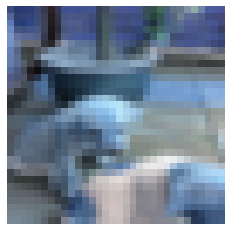

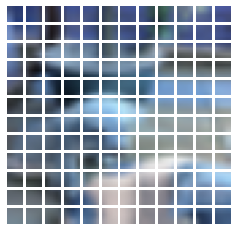

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [40]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [41]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    attention_last_layer = attention_output
    print(attention_last_layer.shape)
    
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [43]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.MeanSquaredError(),
        metrics=[
        keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_root_mean_squared_error",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    loss, rmse = model.evaluate(x_test, y_test)
    print(f"Loss: {loss:0.2f}")
    print(f"RMSE: {rmse:0.2f}")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


(None, 144, 1)
Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 1728.5555 - root_mean_squared_error: 41.5759 - val_loss: 1981.1941 - val_root_mean_squared_error: 44.5106
Epoch 2/100
1/1 [==============================] - 1s 940ms/step - loss: 1725.9025 - root_mean_squared_error: 41.5440 - val_loss: 1975.9525 - val_root_mean_squared_error: 44.4517
Epoch 3/100
1/1 [==============================] - 1s 942ms/step - loss: 1720.9771 - root_mean_squared_error: 41.4847 - val_loss: 1967.4000 - val_root_mean_squared_error: 44.3554
Epoch 4/100
1/1 [==============================] - 1s 926ms/step - loss: 1712.9569 - root_mean_squared_error: 41.3879 - val_loss: 1954.5149 - val_root_mean_squared_error: 44.2099
Epoch 5/100
1/1 [==============================] - 1s 927ms/step - loss: 1700.7896 - root_mean_squared_error: 41.2406 - val_loss: 1936.1340 - val_root_mean_squared_error: 44.0015
Epoch 6/100
1/1 [==============================] - 1s 913ms/step - loss: 1683.8561 - root_m

In [45]:
vit_classifier.layers[5].output

<KerasTensor: shape=(None, 144, 1) dtype=float32 (created by layer 'multi_head_attention_16')>

In [ ]:
from keras.models import Model

model = vit_classifier  # include here your original model

layer_name = 'multi_head_attention_13'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test)
intermediate_output[1].shape

In [ ]:
import math
test_viz_weights = intermediate_output[1][0]
test_viz_weights = test_viz_weights[tf.newaxis, ...]
print(test_viz_weights.shape)
# Reshape the vizualization weights.
num_patches = tf.shape(test_viz_weights)[-1]
print(num_patches)
height = width = int(math.sqrt(num_patches))
test_viz_weights = layers.Reshape((num_heads, height, width))(test_viz_weights)
print(test_viz_weights.shape)
selected_image = x_test[0]
#print(test_augmented_images[0])
selected_weight = test_viz_weights[0][7]
print(selected_weight.shape)
# Plot the images.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(selected_image)
ax[0].set_title(f"Original")
ax[0].axis("off")
img = ax[1].imshow(selected_image)
ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
ax[1].set_title(f"Attended")
ax[1].axis("off")
plt.axis("off")
plt.show()
plt.close()

In [ ]:
plot_var = intermediate_output[1][0]

In [ ]:
plot_var[0, :, :]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(plot_var[0, :, :])
ax[0].set_title(f"Original")
ax[0].axis("off")
img = ax[1].imshow(x_test[0])
ax[1].imshow(plot_var[0, :, :], cmap="inferno", alpha=0.6, extent=img.get_extent())
ax[1].set_title(f"Attended")
ax[1].axis("off")
plt.axis("off")
plt.show()
plt.close()

In [ ]:
import cv2

cv2.imshow("a", plot_var[0, :, :])